In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import librosa
import scipy
import torch
import torch.nn.functional as F

from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#from transformers import AutoProcessor, AutoModelForCTC
#from phonemizer.backend.espeak.wrapper import EspeakWrapper



from scipy.fft import fft
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


## 1. how waveform stored in computer as a file

 Taking a .wav audio file as an example, if the sampling rate is 16,000 and the duration is 1 second, the raw waveform captures the amplitude variations of 16,000 sound samples within that 1 second. Each element's value ranges from -1 to 1, representing the displacement of the microphone diaphragm. Sound vibrations cause shifts within this range. Therefore, we can observe that each segment of audio data tends to follow a normal distribution.



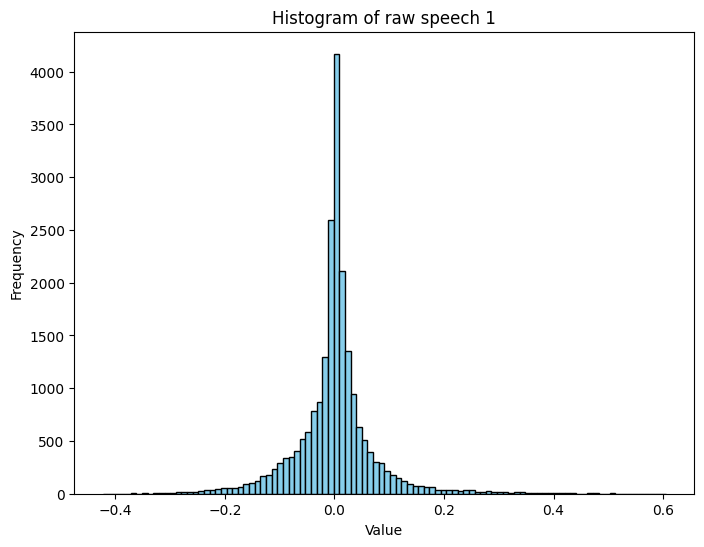

In [90]:
import requests
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
speech1="https://dashpulsar.github.io/BrainlikeASR/Wav_000_A_BOY_FELL_FROM_A_WINDOW.wav"
speech2="https://dashpulsar.github.io/BrainlikeASR/Wav_014_HE_GREW_LOTS_OF_VEGETABLES.wav"
response1 = requests.get(speech1)
response2 = requests.get(speech2)
if response1.status_code == 200:
    audio_file1 = BytesIO(response1.content)
    audio_data1, sr = librosa.load(audio_file1)
    wave_res1 = librosa.resample(audio_data1, orig_sr=sr, target_sr=16000)
if response2.status_code == 200:
    audio_file2 = BytesIO(response2.content)
    audio_data2, sr = librosa.load(audio_file2)
    wave_res2 = librosa.resample(audio_data2, orig_sr=sr, target_sr=16000)

plt.figure(figsize=(8, 6))
plt.hist(wave_res1 , bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of raw speech 1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

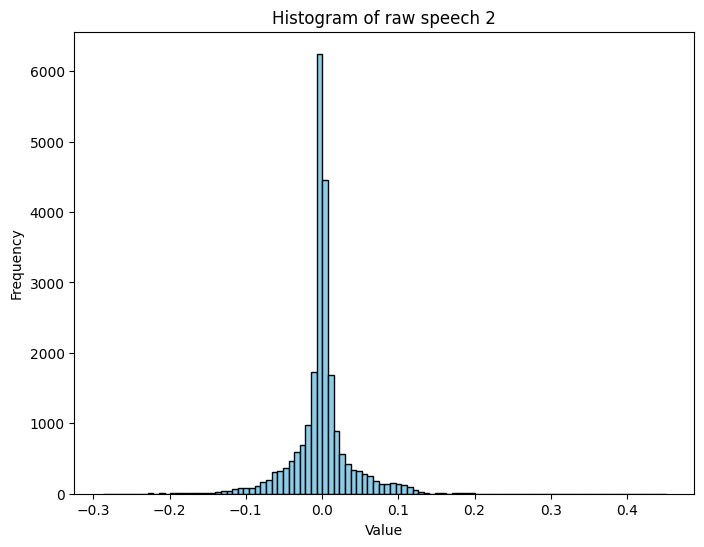

In [91]:
plt.figure(figsize=(8, 6))
plt.hist(wave_res2 , bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of raw speech 2')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

 The reason why audio data segments tend to follow a normal distribution is that the sound waves recorded by the microphone consist of various frequencies and amplitudes. When these sound waves are converted into digital signals, the complex mix of different sound waves, due to the Central Limit Theorem, tends to produce values that approximate a normal distribution. Additionally, the microphone's diaphragm responds to a wide range of sound pressures, which are then translated into electrical signals that are scaled to fit within the range of -1 to 1.

This indicates that we should avoid zero-padding on the raw audio data. Below is an example of the FFT output of two sine waves of different lengths after zero-padding.

Zero-padding in the time domain introduces additional points with a value of zero, effectively altering the original signal's representation in the frequency domain when applying the Fast Fourier Transform (FFT). This can result in artifacts or additional frequency components that were not present in the original signal, leading to a misleading interpretation of the signal's true frequency content. The examples provided demonstrate how two sine waves of different lengths produce distinct FFT outputs after zero-padding, illustrating the distortions or changes in spectral resolution caused by this process.

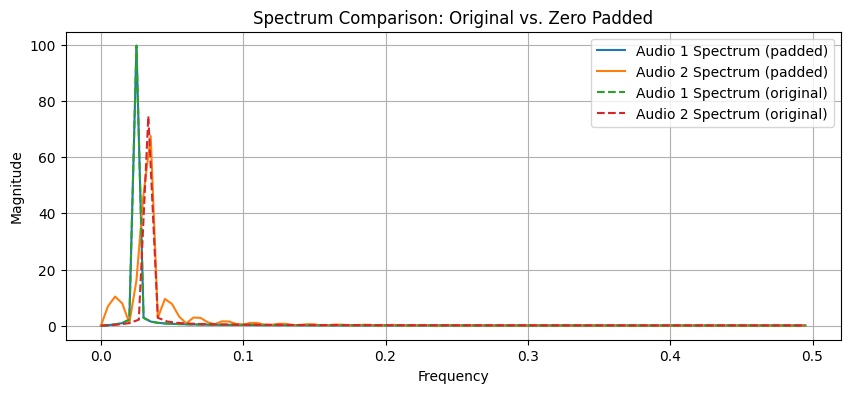

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft


audio1 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 200))  
audio2 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 150))  


target_length = max(len(audio1), len(audio2))


audio1_padded = np.pad(audio1, (0, target_length - len(audio1)), 'constant')
audio2_padded = np.pad(audio2, (0, target_length - len(audio2)), 'constant')
spectrum1_padded = np.abs(fft(audio1_padded))
spectrum2_padded = np.abs(fft(audio2_padded))
spectrum1 = np.abs(fft(audio1))
spectrum2 = np.abs(fft(audio2))


freqs_padded = np.fft.fftfreq(target_length)
freqs1 = np.fft.fftfreq(len(audio1))
freqs2 = np.fft.fftfreq(len(audio2))


plt.figure(figsize=(10, 4))
plt.plot(freqs_padded[:target_length // 2], spectrum1_padded[:target_length // 2], label='Audio 1 Spectrum (padded)')
plt.plot(freqs_padded[:target_length // 2], spectrum2_padded[:target_length // 2], label='Audio 2 Spectrum (padded)')
plt.plot(freqs1[:len(audio1) // 2], spectrum1[:len(audio1) // 2], label='Audio 1 Spectrum (original)', linestyle='--')
plt.plot(freqs2[:len(audio2) // 2], spectrum2[:len(audio2) // 2], label='Audio 2 Spectrum (original)', linestyle='--')

plt.title('Spectrum Comparison: Original vs. Zero Padded')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=200
  warnings.warn(


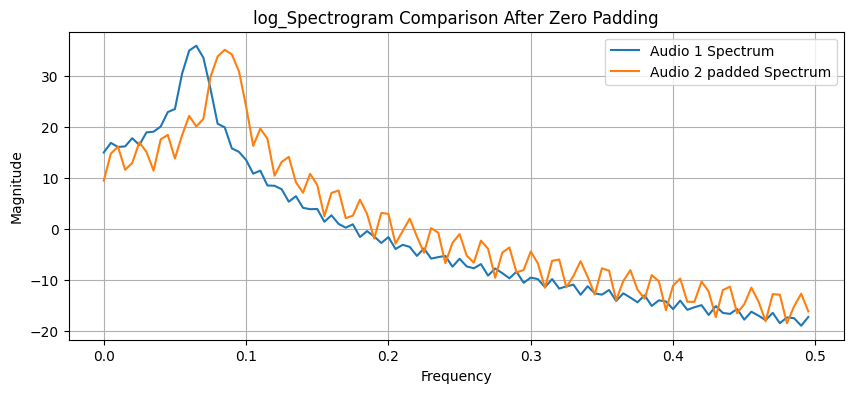

In [19]:


audio1 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 200))  
audio2 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 150))  

target_length = max(len(audio1), len(audio2))


audio1_padded = np.pad(audio1, (0, target_length - len(audio1)), 'constant')
audio2_padded = np.pad(audio2, (0, target_length - len(audio2)), 'constant')



def get_norm_log_spectrogram(audio):
    spectrogram = np.abs(librosa.stft(audio, n_fft=512, hop_length=256)[:-1])
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    #norm_log_spectrogram = normaliser.normalise(log_spectrogram)
    return log_spectrogram#norm_log_spectrogram

spectrum1 = get_norm_log_spectrogram(audio1_padded)
spectrum2 = get_norm_log_spectrogram(audio2_padded)
freqs = np.fft.fftfreq(target_length)


plt.figure(figsize=(10, 4))
plt.plot(freqs[:target_length // 2], spectrum1[:target_length // 2], label='Audio 1 Spectrum')
plt.plot(freqs[:target_length // 2], spectrum2[:target_length // 2], label='Audio 2 padded Spectrum')
plt.title('log_Spectrogram Comparison After Zero Padding')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()


However, after switching to the DTW (Dynamic Time Warping) algorithm, the two sine waves seem to become more similar.(see below) Unlike FFT, which transforms signals into the frequency domain and is sensitive to changes in length or zero-padding, DTW focuses on aligning the sequences in the time domain to find an optimal match. This approach makes it more robust for comparing signals with temporal distortions or length variations. The initial results with simple sine waves are promising, and further analysis will explore its effectiveness in more complex and realistic audio scenarios.

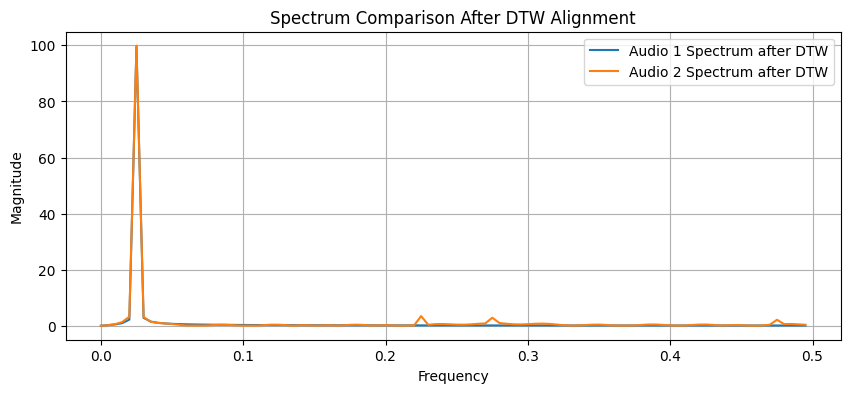

In [6]:



audio1 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 200))  
audio2 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 150))  


distance, path = fastdtw(audio1.reshape(-1,1), audio2.reshape(-1,1), dist=euclidean)


audio1_aligned = []
audio2_aligned = []

for idx1, idx2 in path:
    audio1_aligned.append(audio1[idx1])
    audio2_aligned.append(audio2[idx2])


audio1_aligned = np.array(audio1_aligned)
audio2_aligned = np.array(audio2_aligned)


target_length = max(len(audio1_aligned), len(audio2_aligned))


audio1_padded = np.pad(audio1_aligned, (0, target_length - len(audio1_aligned)), 'constant')
audio2_padded = np.pad(audio2_aligned, (0, target_length - len(audio2_aligned)), 'constant')


spectrum1 = np.abs(fft(audio1_padded))
spectrum2 = np.abs(fft(audio2_padded))


freqs = np.fft.fftfreq(target_length)

plt.figure(figsize=(10, 4))
plt.plot(freqs[:target_length // 2], spectrum1[:target_length // 2], label='Audio 1 Spectrum after DTW')
plt.plot(freqs[:target_length // 2], spectrum2[:target_length // 2], label='Audio 2 Spectrum after DTW')
plt.title('Spectrum Comparison After DTW Alignment')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()



c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=200
  warnings.warn(


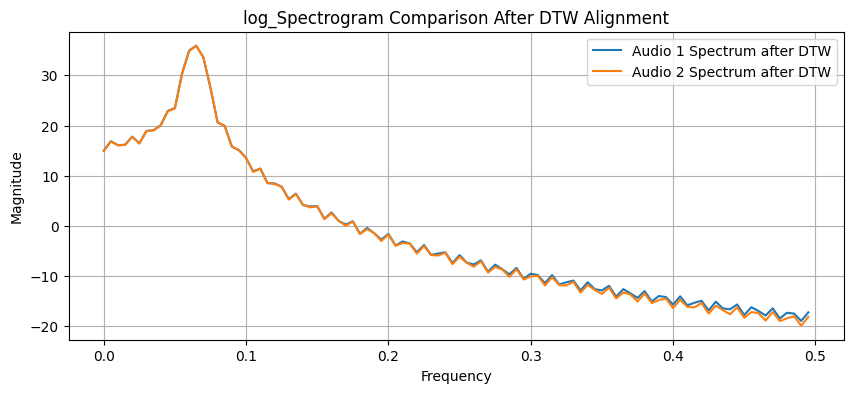

In [18]:
spectrum1 = get_norm_log_spectrogram(audio1_padded)
spectrum2 = get_norm_log_spectrogram(audio2_padded)


freqs = np.fft.fftfreq(target_length)

plt.figure(figsize=(10, 4))
plt.plot(freqs[:target_length // 2], spectrum1[:target_length // 2], label='Audio 1 Spectrum after DTW')
plt.plot(freqs[:target_length // 2], spectrum2[:target_length // 2], label='Audio 2 Spectrum after DTW')
plt.title('log_Spectrogram Comparison After DTW Alignment')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

#### F.interpolate

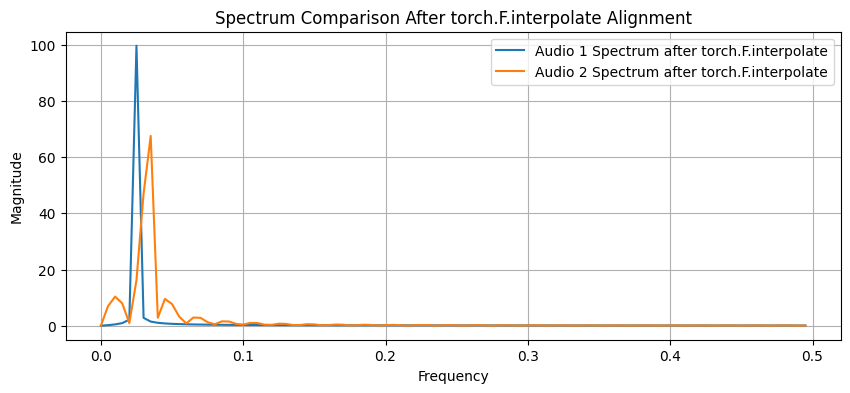

In [21]:


audio1 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 200))  
audio2 = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 150))  


def alignment(audio1,audio2):
    
    audio_tensor_1 = torch.tensor(audio1).unsqueeze(0).unsqueeze(0)  
    audio_tensor_2 = torch.tensor(audio2).unsqueeze(0).unsqueeze(0)

    max_length = max(audio_tensor_1.shape[-1], audio_tensor_2.shape[-1])
    if audio_tensor_1.shape[-1] < max_length:
        audio_tensor_1 = F.interpolate(audio_tensor_1, size=max_length, mode='linear', align_corners=False)
    else:
        audio_tensor_2 = F.interpolate(audio_tensor_2, size=max_length, mode='linear', align_corners=False)
    aligned_audio_1 = audio_tensor_1.squeeze()
    aligned_audio_2 = audio_tensor_2.squeeze()
    return aligned_audio_1.numpy(), aligned_audio_2.numpy()

audio1_aligned ,audio2_aligned =alignment(audio1,audio2)


target_length = max(len(audio1_aligned), len(audio2_aligned))


spectrum1 = np.abs(fft(audio1_padded))
spectrum2 = np.abs(fft(audio2_padded))


freqs = np.fft.fftfreq(target_length)

plt.figure(figsize=(10, 4))
plt.plot(freqs[:target_length // 2], spectrum1[:target_length // 2], label='Audio 1 Spectrum after torch.F.interpolate')
plt.plot(freqs[:target_length // 2], spectrum2[:target_length // 2], label='Audio 2 Spectrum after torch.F.interpolate')
plt.title('Spectrum Comparison After torch.F.interpolate Alignment')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=200
  warnings.warn(


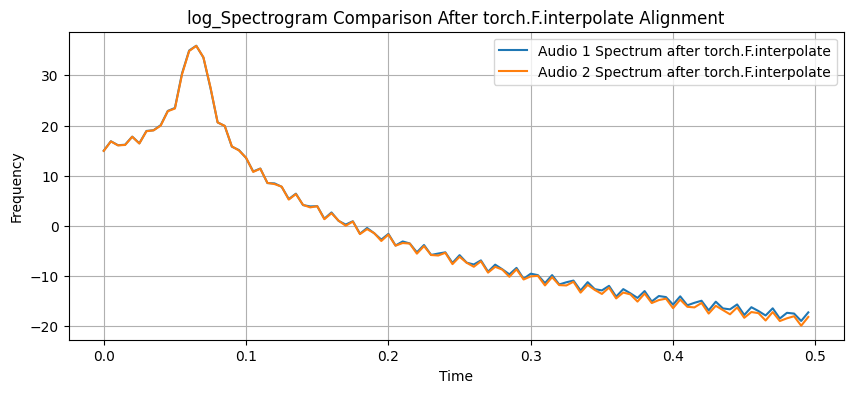

In [17]:

spectrum1 = get_norm_log_spectrogram(audio1_padded)
spectrum2 = get_norm_log_spectrogram(audio2_padded)


freqs = np.fft.fftfreq(target_length)

plt.figure(figsize=(10, 4))
plt.plot(freqs[:target_length // 2], spectrum1[:target_length // 2], label='Audio 1 Spectrum after torch.F.interpolate')
plt.plot(freqs[:target_length // 2], spectrum2[:target_length // 2], label='Audio 2 Spectrum after torch.F.interpolate')
plt.title('log_Spectrogram Comparison After torch.F.interpolate Alignment')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()


 Florian shared a video about transferring a VAE from visual models to audio models. I found that mapping audio of different lengths into mel-spectrograms might potentially solve the problem of differing phoneme lengths. Essentially, if we convert temporal information into frequency information, it seems we can measure distances between these images, although this turns it into a problem somewhat similar to visual computation.

The following figure compares a mel spectrogram and an STFT (Short-Time Fourier Transform) spectrogram.

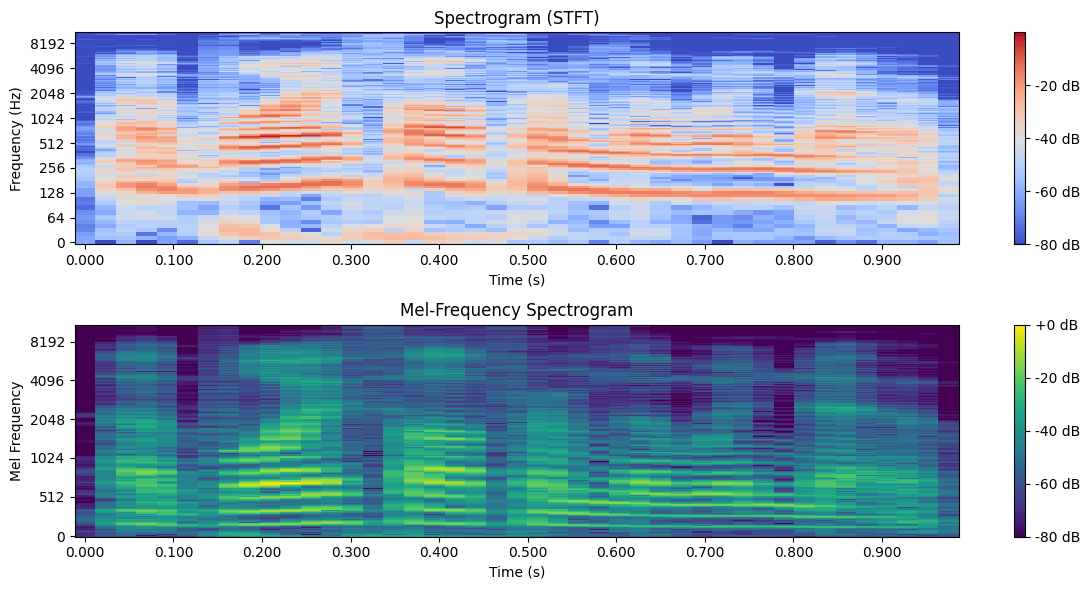

In [36]:



D = librosa.stft(wave_res1)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)


S_mel = librosa.feature.melspectrogram(y=wave_res1, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.subplot(2, 1, 2)
librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Frequency Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

A mel filter bank typically contains a fixed number of filters. In the low-frequency range (e.g., 0 to 1000 Hz), the mel filters are narrow and dense, while in the high-frequency range (e.g., above 1000 Hz), they become wider and sparser. This design reflects the human ear's greater sensitivity to lower frequencies and reduced sensitivity to higher frequencies. The following code demonstrates an example of a mel filter bank with 10 mel filters.

the design of the initial CNN layer in wav2vec2 with 512 kernels suggests an attempt to learn and extract features from raw audio that align with these perceptual characteristics, potentially optimizing the model's performance for speech-related applications.

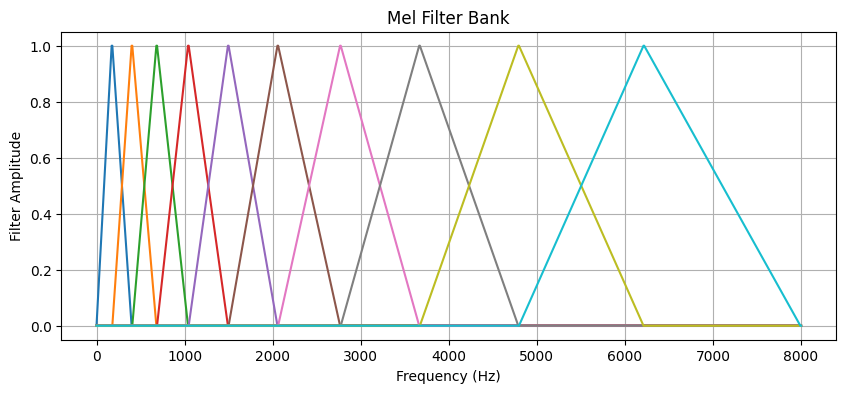

c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


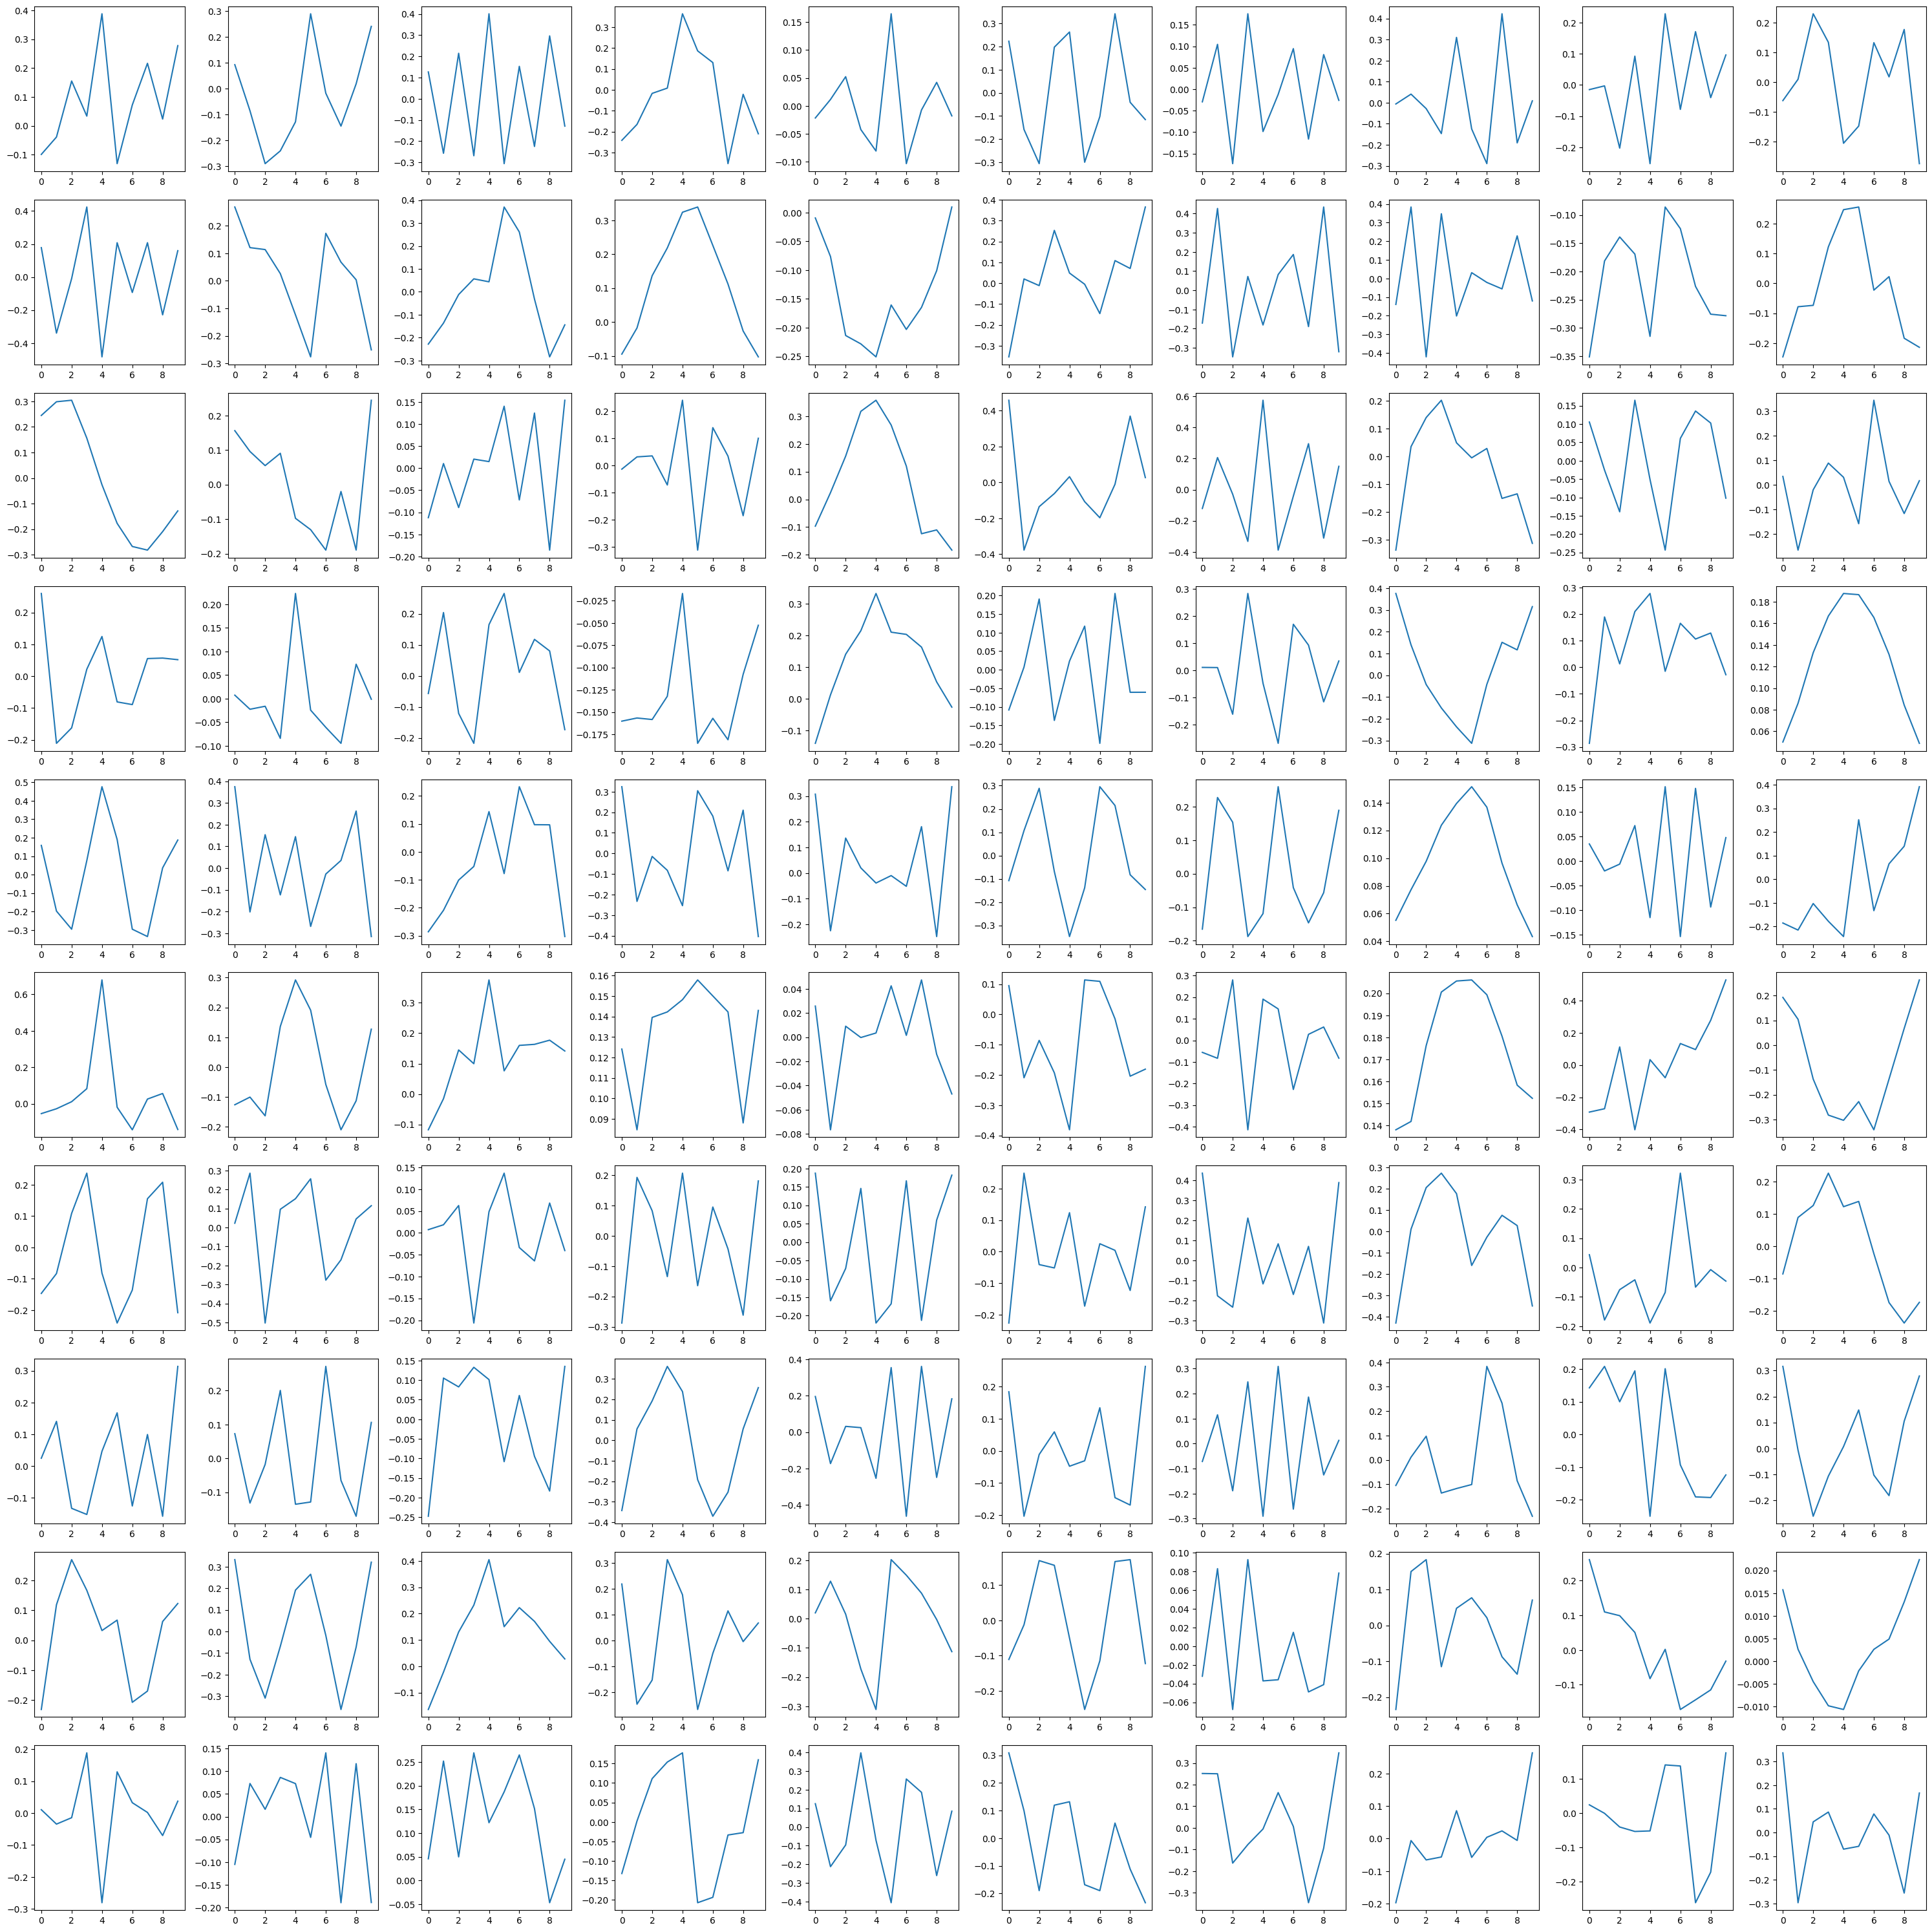

In [55]:



def plot_mel_filter_bank(num_filters=10, sr=16000, n_fft=2048):
    def hz_to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    def mel_to_hz(mel):
        return 700 * (10**(mel / 2595) - 1)

    f_max = sr // 2
    mel_min = hz_to_mel(0)
    mel_max = hz_to_mel(f_max)
    mel_points = np.linspace(mel_min, mel_max, num_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    filters = np.zeros((num_filters, int(n_fft // 2 + 1)))
    for i in range(1, num_filters + 1):
        filters[i - 1, bin_points[i - 1]: bin_points[i]] = np.linspace(0, 1, bin_points[i] - bin_points[i - 1])
        filters[i - 1, bin_points[i]: bin_points[i + 1]] = np.linspace(1, 0, bin_points[i + 1] - bin_points[i])

    plt.figure(figsize=(10, 4))
    for i in range(num_filters):
        plt.plot(np.linspace(0, f_max, int(n_fft // 2 + 1)), filters[i])
    plt.title('Mel Filter Bank')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Filter Amplitude')
    plt.grid(True)
    plt.show()


def plot_wav2vec2_first_layer_kernels():
    model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
    conv_layer = model.feature_extractor.conv_layers[0]
    conv_weights = conv_layer.conv.weight.detach().cpu().numpy()

    num_kernels = conv_weights.shape[0]  
    num_channels = conv_weights.shape[1] 
    kernel_size = conv_weights.shape[2]  

    plt.figure(figsize=(30, 30))
    for i in range(min(100, num_kernels)):  
        plt.subplot(10, 10, i + 1)
        plt.plot(conv_weights[i, 0])  
        #plt.title(f'Kernel {i+1}')
        #plt.xlabel('Kernel Size')
        #plt.ylabel('Weight')
    plt.tight_layout()
    plt.show()

plot_mel_filter_bank()               
plot_wav2vec2_first_layer_kernels()  


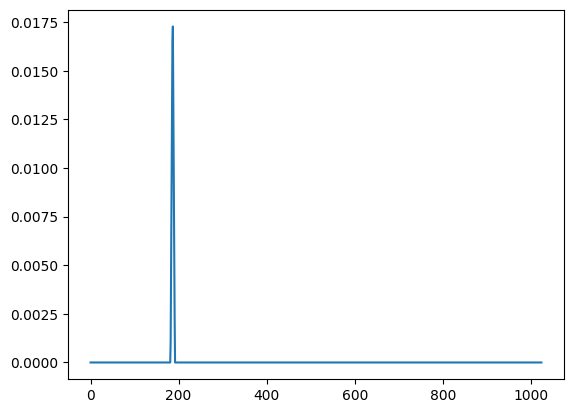

In [54]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=n_mels)
plt.plot(mel[64])